In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
ip_type = 'ipv4'
threshold = '6'
path_to_graphml = f'../data/{ip_type}/graph_Europe_hourly/{threshold}/'
path_to_probes = f'../data/{ip_type}/'
path_to_latency = f'../data/{ip_type}/graph_Europe_hourly/'

In [4]:
# Get all files with .graphml extension
files = [f for f in os.listdir(path_to_graphml) if f.endswith('.graphml')]
files_latency = [f for f in os.listdir(path_to_latency) if f.endswith('.csv') and not(f.startswith('probes'))]
curvature_data = {}
latency_data = {}

# Read Probes.csv file
probes = pd.read_csv(os.path.join(path_to_probes, f'probes_{ip_type}.csv'))
lat_lon_cities = dict(zip(probes['city'],tuple(probes[['latitude','longitude']].values)))
time_series = []
for file in files_latency:
    latency = pd.read_csv(os.path.join(path_to_latency, file))
    ### change dtype of latency
    latency['source_id'] = latency['source_id'].astype('int32')
    latency['target_id'] = latency['target_id'].astype('int32')
    ### change src and dst to str
    latency['source_id'] = latency['source_id'].apply(lambda x: str(x))
    latency['target_id'] = latency['target_id'].apply(lambda x: str(x))
    for src,dst,lat in latency[['source_id','target_id','rtt']].values:
        if src == dst:
            continue
        if (src,dst) not in latency_data:
            latency_data[(src,dst)] = []
        latency_data[(src,dst)].append(lat)
df = pd.DataFrame.from_dict(latency_data, orient='index').transpose()
df.head()

,"(6025, 6031)","(6025, 6039)","(6025, 6042)","(6025, 6043)","(6025, 6049)","(6025, 6081)","(6025, 6087)","(6025, 6094)","(6025, 6117)","(6025, 6120)",...,"(7260, 7208)","(7260, 7210)","(7260, 7212)","(7260, 7213)","(7260, 7231)","(7260, 7234)","(7260, 7236)","(7260, 7249)","(7260, 7254)","(7260, 7258)"
0,9.598924,28.799101,18.849692,18.841919,30.415708,11.648035,18.277560,32.159405,11.688887,23.294961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9.640313,28.757453,18.858757,18.930154,30.328990,11.676641,18.253708,32.059973,11.605283,23.226326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.726621,28.736406,18.856907,18.985731,30.293741,11.680680,18.251682,32.123061,11.515825,23.294344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.674577,28.734147,18.818877,18.904280,30.352163,11.753270,18.254775,32.170980,11.720932,23.203655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.612905,28.786719,18.861015,18.927776,30.343486,11.667158,18.236180,32.225903,11.676818,23.307488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


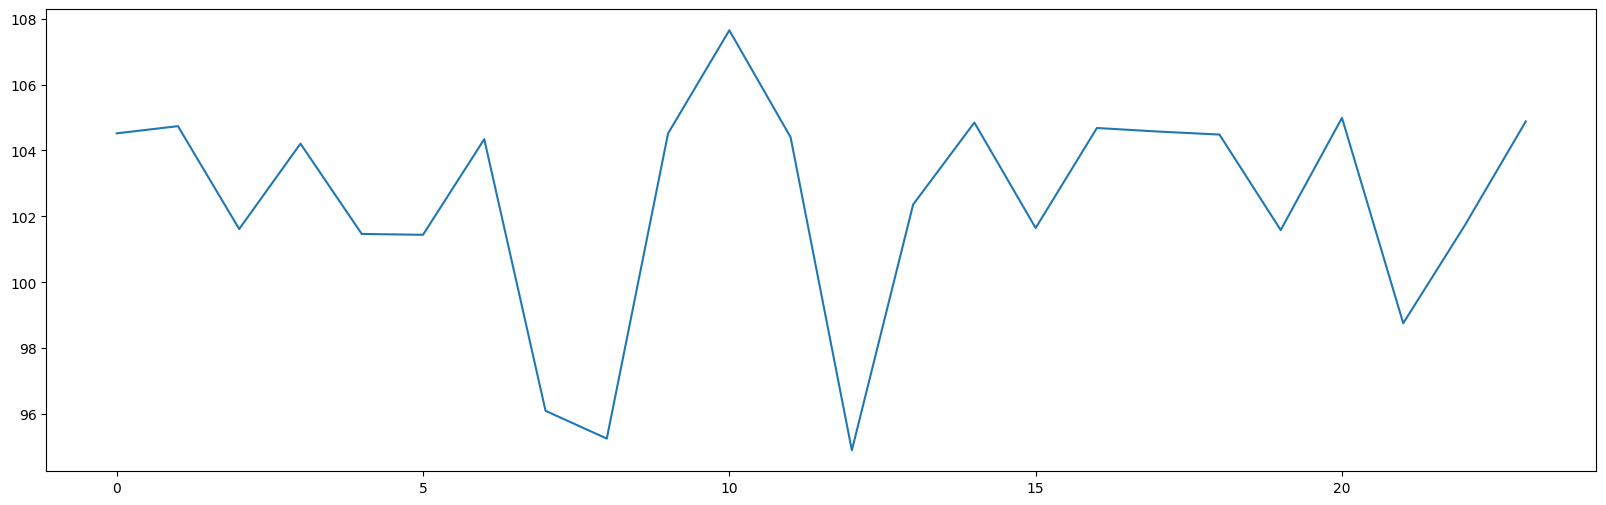

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df[('6043', '6538')].plot(figsize=(20,6))
plt.show()

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 1.91 µs


50850it [00:12, 4006.48it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


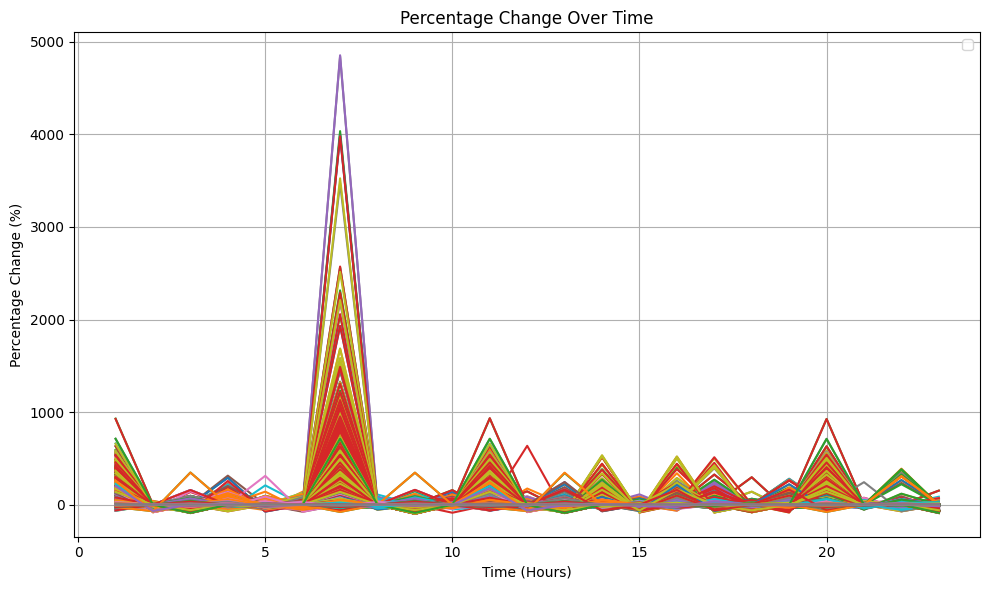

Number of RTT with very stable latencies 42933
Number of RTT with minor changes (above 50% increase but less than 100%) 6204
Number of RTT with major changes (above 100% increase but less than 100%) 1713


In [6]:
%time
from tqdm import tqdm
# Compute percentage changes
df_pct_change = df.pct_change() * 100  # multiply by 100 to get percentage
# Remove the first value
df_pct_change = df_pct_change.iloc[1:]

# Plot
plt.figure(figsize=(10, 6))
minor_changes = 0
stable_latency = 0
major_changes = 0
edges = []
elements_with_major_changes = []
for i, column in tqdm(enumerate(df_pct_change.columns)):
    if max(df_pct_change[column]) > 300:
        plt.plot(df_pct_change.index, df_pct_change[column])
        elements_with_major_changes.append(probes[probes['id'] == int(column[0])]['city'].values[0])
        elements_with_major_changes.append(probes[probes['id'] == int(column[1])]['city'].values[0])
        edges.append((probes[probes['id'] == int(column[0])]['city'].values[0],probes[probes['id'] == int(column[1])]['city'].values[0]))
                 # label=str(probes[probes['id'] == int(column[0])]['city'].values[0] + '-' + probes[probes['id'] == int(column[1])]['city'].values[0]))
    else:
    #     pass
        plt.plot(df_pct_change.index, df_pct_change[column])
    if max(df_pct_change[column]) > 50:
        major_changes += 1
    elif max(df_pct_change[column]) > 10:
        minor_changes += 1
    else:
        stable_latency += 1
### make this log scale
# plt.yscale('log')
plt.title('Percentage Change Over Time')
plt.xlabel('Time (Hours)')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print('Number of RTT with very stable latencies', stable_latency)
print('Number of RTT with minor changes (above 50% increase but less than 100%)',minor_changes )
print('Number of RTT with major changes (above 100% increase but less than 100%)', major_changes)

In [20]:
df.pct_change()*100

,"(6025, 6031)","(6025, 6039)","(6025, 6042)","(6025, 6043)","(6025, 6049)","(6025, 6081)","(6025, 6087)","(6025, 6094)","(6025, 6117)","(6025, 6120)",...,"(7260, 7208)","(7260, 7210)","(7260, 7212)","(7260, 7213)","(7260, 7231)","(7260, 7234)","(7260, 7236)","(7260, 7249)","(7260, 7254)","(7260, 7258)"
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.431184,-0.144616,0.048091,0.468291,-0.285109,0.245586,-0.130499,-0.309185,-0.715243,-0.294635,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.895282,-0.073188,-0.009810,0.293590,-0.116222,0.034590,-0.011099,0.196781,-0.770839,0.292849,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.535068,-0.007861,-0.201677,-0.429012,0.192852,0.621454,0.016946,0.149173,1.781088,-0.389318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.637465,0.182960,0.223913,0.124289,-0.028588,-0.732664,-0.101864,0.170722,-0.376369,0.447486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.534251,0.157142,-0.193001,0.006451,0.054166,0.945243,0.327168,-0.180467,-0.067827,-0.326320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.309863,-0.310697,-0.109792,-0.255085,0.058581,-0.187019,0.083642,0.238245,0.247847,-0.150460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-0.874584,0.098238,0.233988,0.207805,-0.278141,0.015916,-0.040729,-0.060959,-0.313682,0.183963,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.165046,-0.026718,-0.088121,-0.216666,0.216969,-0.108188,-0.149806,-0.039411,-0.074195,-0.077301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-0.539683,-0.050176,-0.244699,-0.129149,0.079785,-0.424290,-0.206618,-0.003884,0.046119,-0.199852,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
from collections import defaultdict
count_elements_with_major_changes = defaultdict(lambda : 0)
for i in elements_with_major_changes:
    count_elements_with_major_changes[i] += 1
dict(sorted(count_elements_with_major_changes.items(), key=lambda item: item[1]))

{'Rennes': 1,
 'Peterborough': 1,
 'Donetsk': 1,
 'Poland': 1,
 'Strasbourg': 2,
 'Amsterdam': 2,
 'Vienna': 2,
 'Stockholm': 2,
 'Slough': 2,
 'Milan': 2,
 'Berlin': 2,
 'Klagenfurt': 2,
 'Tallinn': 2,
 'Braunschweig': 2,
 'Aalborg': 2,
 'Rome': 2,
 'Ede': 2,
 'Vilnius': 2,
 'Helsinki': 2,
 'Esch-sur-Alzette': 2,
 'Karlsruhe': 2,
 'Tampere': 2,
 'Zürich': 2,
 'Oslo': 2,
 'Paris': 2,
 'Torino': 2,
 'Katowice': 2,
 'Siauliai': 2,
 'Kyiv': 2,
 'Zagreb': 2,
 'Mainz': 2,
 'Ballerup': 2,
 'Magdeburg': 2,
 'Malmö': 2,
 'Barcelona': 2,
 'Dortmund': 2,
 'Sarajevo': 2,
 'Neubiberg': 2,
 'Capelle aan den IJssel': 2,
 'Cesson- Sevigne': 2,
 'Mannheim': 2,
 'Mutterstadt': 2,
 'Glattbrugg': 2,
 'Toulouse': 2,
 'Munchen': 2,
 'Mykolayiv': 2,
 'Meran': 2,
 'Copenhagen': 2,
 'ROZZANO': 2,
 'Belgrade': 2,
 'Lund': 2,
 'Dübendorf': 2,
 'Timisoara': 2,
 'Northampton': 2,
 'Arezzo': 2,
 'Nanterre': 2,
 'Rotterdam': 2,
 'Redhill': 2,
 'Bettembourg': 2,
 'Lausanne': 2,
 'Münchenstein': 2,
 'Bremen': 2,
 'Pr

In [101]:
import folium

m = folium.Map(location=[50, 10], zoom_start=4)


for city, count in count_elements_with_major_changes.items():
    lat, lon = lat_lon_cities[city]
    folium.CircleMarker(
        location=[lat, lon],
        radius=count/20,  # you might need to adjust this value for better visualization
        popup=city,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(m)

m.save('map.html')
m

In [102]:
lat_lon_cities

{'Minsk': array([53.8915, 27.4605]),
 'Sofia': array([42.6685, 23.3975]),
 'Silistra': array([44.1195, 27.2595]),
 'Varna': array([43.2075, 27.9305]),
 'Prague': array([50.0595, 14.4795]),
 'Brno': array([49.2115, 16.6015]),
 'Budapest': array([47.5015, 19.0385]),
 'Szeged': array([46.2595, 20.1505]),
 'Katowice': array([50.2485, 18.9985]),
 'Warsaw': array([52.2315, 21.0005]),
 'Ozarów Mazowiecki': array([52.2075, 20.8075]),
 'Szczecin': array([53.5005, 14.5895]),
 'Poland': array([52.9895, 18.6705]),
 'Bialystok': array([53.1315, 23.0895]),
 'Chisinau': array([47.0175, 28.8375]),
 'Bucharest': array([44.4205, 26.0975]),
 'Iasi': array([47.1585, 27.5895]),
 'Timisoara': array([45.7695, 21.2305]),
 'Drobeta-Turnu Severin': array([44.6405, 22.6585]),
 'Moscow': array([55.7595, 37.6185]),
 'Ivanovo': array([56.9905, 40.9885]),
 'Novosibirsk': array([55.0315, 82.9385]),
 'Saint-Petersburg': array([59.8785, 30.4285]),
 'Chita': array([ 52.0295, 113.4985]),
 'Omsk': array([54.9885, 73.3595]

In [103]:
elements_with_major_changes

['Strasbourg',
 'Oxford',
 'Amsterdam',
 'Oxford',
 'Budapest',
 'San Benedetto del Tronto',
 'Budapest',
 'Oxford',
 'Budapest',
 'Battipaglia',
 'Vienna',
 'Oxford',
 'Prévessin-Moëns',
 'Oxford',
 'Prévessin-Moëns',
 'Bolton',
 'Stockholm',
 'Oxford',
 'Nuremberg',
 'Oxford',
 'Nuremberg',
 'Bolton',
 'Slough',
 'Oxford',
 'Milan',
 'Oxford',
 'Berlin',
 'Oxford',
 'Klagenfurt',
 'Oxford',
 'Riga',
 'Oxford',
 'Riga',
 'Tallinn',
 'Braunschweig',
 'Oxford',
 'Düsseldorf',
 'Oxford',
 'Düsseldorf',
 'Bolton',
 'Düsseldorf',
 'Dublin',
 'Aalborg',
 'Oxford',
 'Rome',
 'Oxford',
 'Ede',
 'Oxford',
 'Hamburg',
 'Oxford',
 'Hamburg',
 'Bolton',
 'Vilnius',
 'Oxford',
 'Helsinki',
 'Oxford',
 'Esch-sur-Alzette',
 'Oxford',
 'Karlsruhe',
 'Oxford',
 'Tampere',
 'Oxford',
 'Veendam',
 'Oxford',
 'Zürich',
 'Oxford',
 'Oslo',
 'Oxford',
 'Grünwald',
 'Salzburg',
 'Grünwald',
 'Oxford',
 'Grünwald',
 'Bolton',
 'Grünwald',
 'Battipaglia',
 'Grünwald',
 'Dublin',
 'Grünwald',
 'Szeged',
 'Grün

In [104]:
import folium
import networkx as nx

m = folium.Map(location=[50, 10], zoom_start=4)

# 1. Graph Creation with NetworkX
G = nx.Graph()
G.add_edges_from(edges)

# Draw nodes on the folium map
for city, count in count_elements_with_major_changes.items():
    lat, lon = lat_lon_cities[city]
    folium.CircleMarker(
        location=[lat, lon],
        radius=count/20,  # you might need to adjust this value for better visualization
        popup=city,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(m)

# 2. Add Graph to Folium Map
for edge in G.edges():
    start_point = lat_lon_cities[edge[0]]
    end_point = lat_lon_cities[edge[1]]
    folium.PolyLine(locations=[start_point, end_point], color="red", weight=2.5, opacity=0.1).add_to(m)
m.save(f'map_{ip_type}.html')
m